Data source: 

https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

# Get data and packages

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import re
import string
import optuna
from functools import partial
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import warnings

In [4]:
warnings.filterwarnings("ignore")

In [6]:
df_train = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')
df_train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [9]:
df_test = pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')
df_test

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [11]:
X = df_train.loc[:, 'OriginalTweet']
y = df_train.loc[:, 'Sentiment']
X_test =  df_test.loc[:, 'OriginalTweet']
y_test = df_test.loc[:, 'Sentiment']

# Data cleaning

In [12]:
def clean_text(text):

    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    
    return text

In [13]:
X_clean = X.apply(clean_text)
X_test_clean = X_test.apply(clean_text)

# Data split

In [14]:
lb = LabelEncoder()
y_lb = lb.fit_transform(y)

X_train, X_valid, y_train, y_valid = train_test_split(X_clean, y_lb, test_size=0.1, random_state=1)

# Using SVM

# Bag of words

In [10]:
vectorizer = CountVectorizer(stop_words = 'english', binary = True, ngram_range = (1,2))

In [11]:
X_train_bow =  vectorizer.fit_transform(X_train)
X_valid_bow =  vectorizer.transform(X_valid)

In [12]:
clf_svm_bow = svm.SVC(kernel='linear')
clf_svm_bow.fit(X_train_bow, y_train)
preds_svm_bow = clf_svm_bow.predict(X_valid_bow)

In [13]:
def conf_matrix(valid, preds, labels):
    
    cm = confusion_matrix(y_valid, preds)
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(12,12))
    cmp.plot(ax=ax)

    print("ACCURACY: ", accuracy_score(preds, y_valid))

ACCURACY:  0.61977648202138


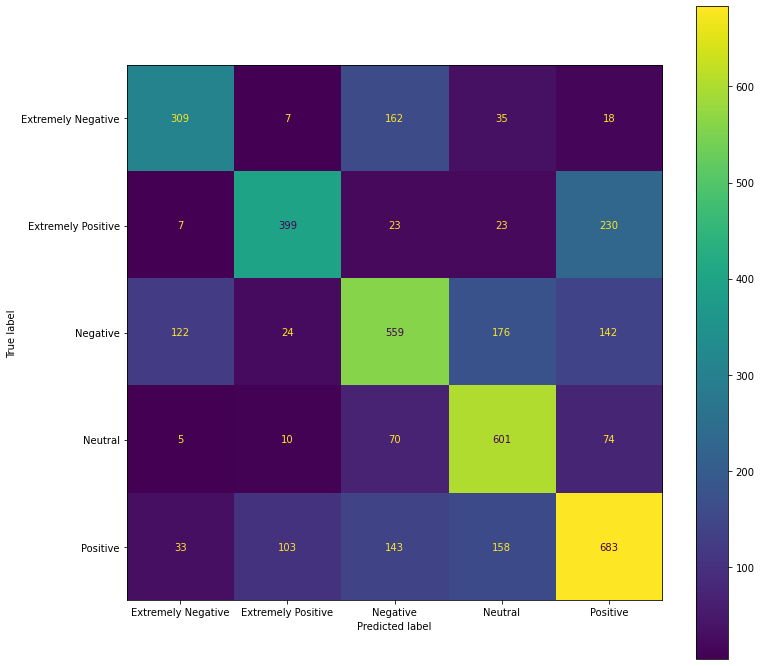

In [14]:
conf_matrix(y_valid, preds_svm_bow, lb.classes_)

# TF-IDF

In [15]:
tfidf = TfidfVectorizer(stop_words = 'english')

In [16]:
X_train_tfidf =  tfidf.fit_transform(X_train)
X_valid_tfidf =  tfidf.transform(X_valid)

In [17]:
clf_svm_tfidf = svm.SVC(kernel='linear')
clf_svm_tfidf.fit(X_train_tfidf, y_train)
preds_svm_tfidf = clf_svm_tfidf.predict(X_valid_tfidf)

ACCURACY:  0.6134596695821186


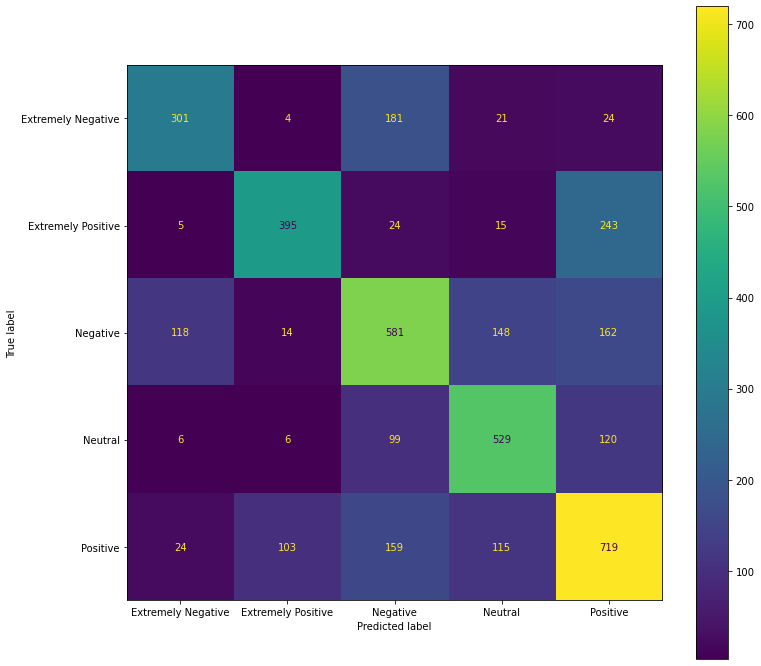

In [18]:
conf_matrix(y_valid, preds_svm_tfidf, lb.classes_)

# Adding lemmatization to the TF-IDF model

In [19]:
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [20]:
X_train_lemma = []

for tweet in X_train:
    
    lemma_tweet = lemmatizer.lemmatize(tweet)
    X_train_lemma.append(lemma_tweet)
    
X_valid_lemma = []

for tweet in X_valid:
    
    lemma_tweet = lemmatizer.lemmatize(tweet)
    X_valid_lemma.append(lemma_tweet)

In [21]:
X_train_lemma_tfidf =  tfidf.fit_transform(X_train_lemma)
X_valid_lemma_tfidf =  tfidf.transform(X_valid_lemma)

In [22]:
clf_svm_lemma_tfidf = svm.SVC(kernel='linear')
clf_svm_lemma_tfidf.fit(X_train_lemma_tfidf, y_train)
preds_svm_lemma_tfidf = clf_svm_lemma_tfidf.predict(X_valid_lemma_tfidf)

ACCURACY:  0.6134596695821186


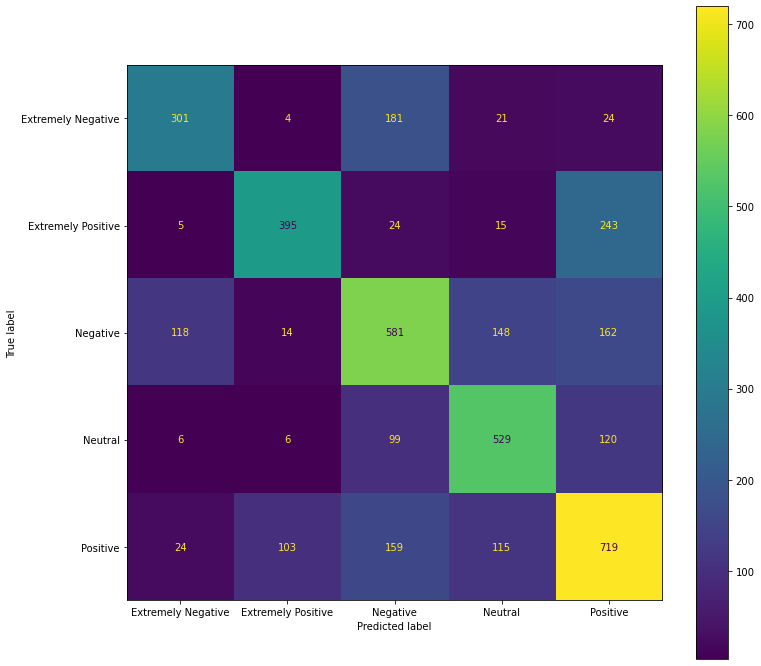

In [23]:
conf_matrix(y_valid, preds_svm_lemma_tfidf, lb.classes_)

# GloVe and LSTM

In [24]:
def create_corpus_tk(df):
    
    corpus = []
    for text in X_clean:
        words = [word for word in word_tokenize(text)]
        corpus.append(words)
        
    return corpus 

In [25]:
def padding(X_train, X_valid, dim = 50):
    
    corpus = create_corpus_tk(X_train)
    corpus_num_words = len(corpus)
    
    tokenizer = Tokenizer(num_words = corpus_num_words)
    tokenizer.fit_on_texts(X_train)
    
    train_sequences = tokenizer.texts_to_sequences(X_train)
    train_padded = pad_sequences(train_sequences, maxlen = dim, truncating = 'post', padding = 'post')
    
    valid_sequences = tokenizer.texts_to_sequences(X_valid)
    valid_padded = pad_sequences(valid_sequences, maxlen = dim, truncating = 'post', padding = 'post')
    
    word_index = tokenizer.word_index
    
    return train_padded, valid_padded, word_index

In [26]:
train_padded, valid_padded, word_index = padding(X_train, X_valid)

In [27]:
def get_glove_embedding(word_index, dim = 50):

    embeddings_dict={}
    with open('./glove.twitter.27B.50d.txt','rb') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
            
    EMBEDDING_DIM = embeddings_dict.get(b'a').shape[0]
    num_words = max(dim, len(word_index)) + 1
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i > num_words:
            continue
        embedding_vector = embeddings_dict.get(word.encode("utf-8")) 
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return num_words, embedding_matrix

In [28]:
num_words, embedding_matrix = get_glove_embedding(word_index)

# LSTM with GloVe

In [29]:
model = Sequential()

model.add(
    Embedding(
        num_words,
        50,
        embeddings_initializer = Constant(embedding_matrix),
        input_length = 50,
        trainable = False,
    )
)
model.add(LSTM(50, dropout = 0.1))
model.add(Dense(5, activation = 'softmax'))

optimizer = Adam()

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
r = model.fit(train_padded, y_train, epochs = 100, validation_data = (valid_padded, y_valid), callbacks=[callback])

Epoch 1/100
1158/1158 [==============================] - 16s 13ms/step - loss: 1.3865 - accuracy: 0.3823 - val_loss: 1.2214 - val_accuracy: 0.4845
Epoch 2/100
1158/1158 [==============================] - 14s 12ms/step - loss: 1.2180 - accuracy: 0.4761 - val_loss: 1.1632 - val_accuracy: 0.5063
Epoch 3/100
1158/1158 [==============================] - 15s 13ms/step - loss: 1.1652 - accuracy: 0.5047 - val_loss: 1.1351 - val_accuracy: 0.5328
Epoch 4/100
1158/1158 [==============================] - 15s 13ms/step - loss: 1.1281 - accuracy: 0.5238 - val_loss: 1.1010 - val_accuracy: 0.5442
Epoch 5/100
1158/1158 [==============================] - 15s 13ms/step - loss: 1.1016 - accuracy: 0.5355 - val_loss: 1.0880 - val_accuracy: 0.5549
Epoch 6/100
1158/1158 [==============================] - 15s 13ms/step - loss: 1.0795 - accuracy: 0.5476 - val_loss: 1.0594 - val_accuracy: 0.5646
Epoch 7/100
1158/1158 [==============================] - 15s 13ms/step - loss: 1.0599 - accuracy: 0.5571 - val_loss: 1

In [31]:
preds_lstm = np.around(model.predict(valid_padded))
preds_lstm_final = np.array([np.argmax(preds_lstm[i]) for i in range(len(preds_lstm))]).astype(int)

In [32]:
preds_lstm_final

array([2, 2, 1, ..., 3, 0, 2])

ACCURACY:  0.6321671525753159


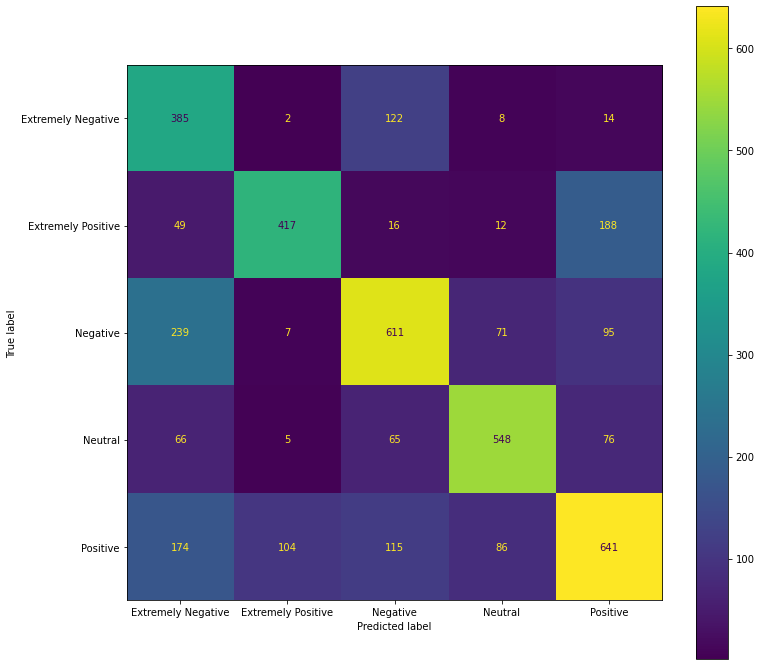

In [33]:
conf_matrix(y_valid, preds_lstm_final, lb.classes_)

# Switching to 3-class problem

In [34]:
y_3class = y.copy()
for i in range(len(y)):
    
    if y_3class[i] == 'Extremely Negative':
        
        y_3class[i] = 'Negative'
        
    if y_3class[i] == 'Extremely Positive':
        
        y_3class[i] = 'Positive'
        
lb_3class = LabelEncoder()
y_lb_3class = lb_3class.fit_transform(y_3class)

X_train, X_valid, y_train, y_valid = train_test_split(X_clean, y_lb_3class, test_size=0.1, random_state=1)

In [35]:
train_padded, valid_padded, word_index = padding(X_train, X_valid)

In [36]:
num_words, embedding_matrix = get_glove_embedding(word_index)

In [37]:
model = Sequential()

model.add(
    Embedding(
        num_words,
        50,
        embeddings_initializer = Constant(embedding_matrix),
        input_length = 50,
        trainable = False,
    )
)
model.add(LSTM(100, dropout = 0.2, return_sequences = True))
model.add(LSTM(50, dropout = 0.2))
model.add(Dense(3, activation = 'softmax'))

optimizer = Adam()

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
r = model.fit(train_padded, y_train, epochs = 100, validation_data = (valid_padded, y_valid), callbacks=[callback])

Epoch 1/100
1158/1158 [==============================] - 39s 32ms/step - loss: 0.8905 - accuracy: 0.5788 - val_loss: 0.7845 - val_accuracy: 0.6535
Epoch 2/100
1158/1158 [==============================] - 43s 37ms/step - loss: 0.7917 - accuracy: 0.6536 - val_loss: 0.7317 - val_accuracy: 0.6929
Epoch 3/100
1158/1158 [==============================] - 43s 37ms/step - loss: 0.7518 - accuracy: 0.6737 - val_loss: 0.6944 - val_accuracy: 0.7048
Epoch 4/100
1158/1158 [==============================] - 46s 39ms/step - loss: 0.7209 - accuracy: 0.6903 - val_loss: 0.6591 - val_accuracy: 0.7259
Epoch 5/100
1158/1158 [==============================] - 43s 38ms/step - loss: 0.6914 - accuracy: 0.7078 - val_loss: 0.6392 - val_accuracy: 0.7386
Epoch 6/100
1158/1158 [==============================] - 44s 38ms/step - loss: 0.6670 - accuracy: 0.7201 - val_loss: 0.6292 - val_accuracy: 0.7371
Epoch 7/100
1158/1158 [==============================] - 44s 38ms/step - loss: 0.6441 - accuracy: 0.7322 - val_loss: 0

In [40]:
preds_lstm2 = np.around(model.predict(valid_padded))
preds_lstm2_final = np.array([np.argmax(preds_lstm2[i]) for i in range(len(preds_lstm2))]).astype(int)

ACCURACY:  0.79421768707483


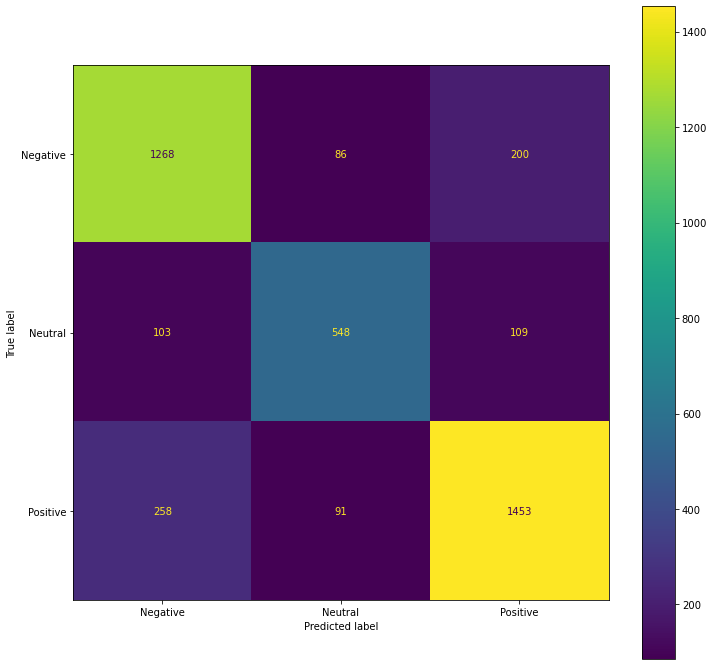

In [41]:
conf_matrix(y_valid, preds_lstm2_final, lb_3class.classes_)